In [121]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import linearmodels as lm
from linearmodels import PanelOLS

In [122]:
data_path = r'C:\Projects\connecteddatahub\data'

citations_path = os.path.join(data_path, 'external', 'institution_top_fraction.csv')
academic_programs_path = os.path.join(data_path, 'external', 'university_academics_program_percent.csv')

nodes_path = os.path.join(data_path, 'interlocks', 'interlock_nodes.csv')
edges_path = os.path.join(data_path, 'interlocks', 'interlock_edges.csv')

In [123]:
citations_df = pd.read_csv(citations_path)
citations_df['Year'] = citations_df['year']
citations_df.columns

Index(['AffiliationId', 'TotalPublications', 'Top5PercentPublications',
       'Top5PercentFraction', 'year', 'Year'],
      dtype='object')

In [124]:
academic_programs_df = pd.read_csv(academic_programs_path)
academic_programs_df.columns

Index(['carnegie_id', 'AffiliationId', 'year',
       'academics.program_percentage.agriculture',
       'academics.program_percentage.resources',
       'academics.program_percentage.architecture',
       'academics.program_percentage.ethnic_cultural_gender',
       'academics.program_percentage.communication',
       'academics.program_percentage.communications_technology',
       'academics.program_percentage.computer',
       'academics.program_percentage.personal_culinary',
       'academics.program_percentage.education',
       'academics.program_percentage.engineering',
       'academics.program_percentage.engineering_technology',
       'academics.program_percentage.language',
       'academics.program_percentage.family_consumer_science',
       'academics.program_percentage.legal',
       'academics.program_percentage.english',
       'academics.program_percentage.humanities',
       'academics.program_percentage.library',
       'academics.program_percentage.biological',
    

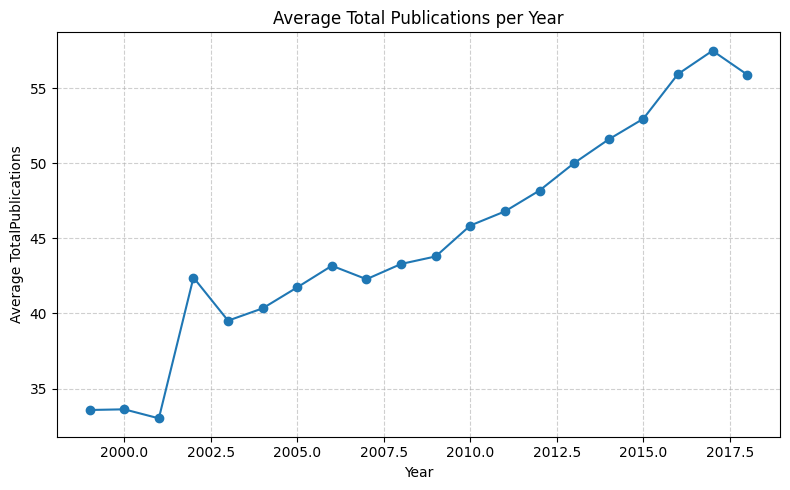

In [125]:
'''plot growth rate of citations'''
citations_df['year'] = citations_df['year'].astype(int)

# Compute mean TotalPublications per year
avg_publications = citations_df.groupby('year')['TotalPublications'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(avg_publications['year'], avg_publications['TotalPublications'], marker='o')
plt.title('Average Total Publications per Year')
plt.xlabel('Year')
plt.ylabel('Average TotalPublications')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\tykun\AppData\Local\Temp\ipykernel_17260\582087120.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top50 = citations_df.groupby('year', group_keys=False).apply(top_half)


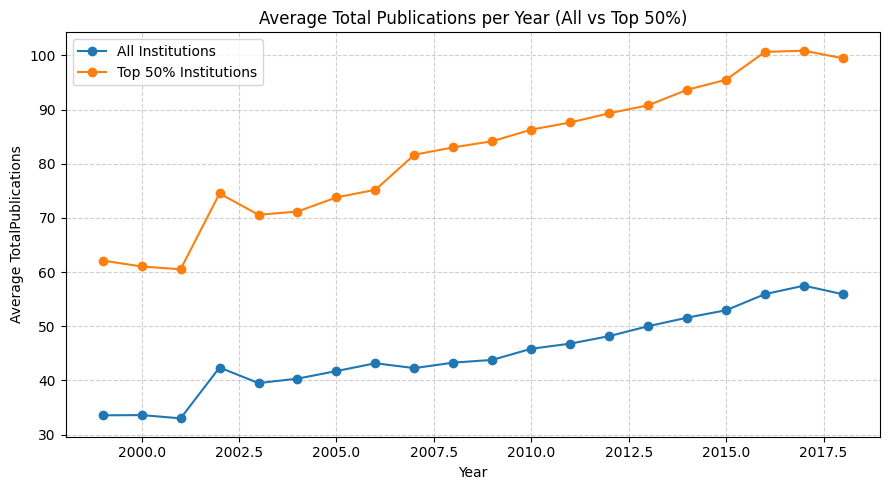

In [126]:
avg_all = citations_df.groupby('year')['TotalPublications'].mean().reset_index()

def top_half(group):
    cutoff = group['TotalPublications'].median()
    return group[group['TotalPublications'] >= cutoff]

df_top50 = citations_df.groupby('year', group_keys=False).apply(top_half)
avg_top50 = df_top50.groupby('year')['TotalPublications'].mean().reset_index()

plt.figure(figsize=(9, 5))

plt.plot(avg_all['year'], avg_all['TotalPublications'], label='All Institutions', marker='o')
plt.plot(avg_top50['year'], avg_top50['TotalPublications'], label='Top 50% Institutions', marker='o')

plt.title('Average Total Publications per Year (All vs Top 50%)')
plt.xlabel('Year')
plt.ylabel('Average TotalPublications')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [127]:
interlocks_df = pd.read_csv(nodes_path)
print(interlocks_df.columns)
print('\n\n')
edges_df = pd.read_csv(edges_path)
print(edges_df.columns)


Index(['Year', 'Id', 'Label', 'SystemId', 'degree', 'degree_centrality',
       'eigenvector_centrality', 'betweenness_centrality', 'clustering',
       'modularity_class', 'interlock_entropy_bits', 'strength', 'Institution',
       'AffiliationId'],
      dtype='object')



Index(['Year', 'AffiliationId_1', 'Institution_1', 'AffiliationId_2',
       'Institution_2', 'InterlockCount', 'BoardSize_1', 'BoardSize_2',
       'WeightNorm', 'Weakness', 'Source', 'Target', 'Weight',
       'EdgeEntropyBits'],
      dtype='object')


In [128]:
edges = edges_df.merge(
    citations_df.rename(columns={'AffiliationId': 'AffiliationId_1'}),
    on=['AffiliationId_1', 'Year'],
    how='left',
    suffixes=('', '_1')
).merge(
    citations_df.rename(columns={'AffiliationId': 'AffiliationId_2'}),
    on=['AffiliationId_2', 'Year'],
    how='left',
    suffixes=('_1', '_2')
)


In [129]:
partner_strength = (
    edges.groupby(['Year', 'AffiliationId_1'])
    .apply(lambda g: (g['TotalPublications_2'] * g['WeightNorm']).sum() / g['WeightNorm'].sum())
    .reset_index(name='PartnerAvgPublications')
)


C:\Users\tykun\AppData\Local\Temp\ipykernel_17260\685487077.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['TotalPublications_2'] * g['WeightNorm']).sum() / g['WeightNorm'].sum())


In [130]:
school_panel = citations_df.merge(partner_strength, left_on=['AffiliationId','Year'], right_on=['AffiliationId_1','Year'], how='left')
school_panel = school_panel.sort_values(['AffiliationId','Year'])
school_panel['ΔPublications'] = school_panel.groupby('AffiliationId')['TotalPublications'].diff()

In [131]:
df = school_panel.dropna(subset=['ΔPublications', 'PartnerAvgPublications', 'Year', 'AffiliationId'])

m = smf.ols(
    'ΔPublications ~ PartnerAvgPublications + C(Year)',
    data=df
).fit(cov_type='cluster', cov_kwds={'groups': df['AffiliationId']})

print(m.summary())


                            OLS Regression Results                            
Dep. Variable:          ΔPublications   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     5.312
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.32e-06
Time:                        00:12:10   Log-Likelihood:                -3895.2
No. Observations:                 628   AIC:                             7812.
Df Residuals:                     617   BIC:                             7861.
Df Model:                          10                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

In [132]:
school_panel['PartnerAvgPublications_lag'] = school_panel.groupby('AffiliationId')['PartnerAvgPublications'].shift(1)

fe = lm.PanelOLS.from_formula(
    'TotalPublications ~ PartnerAvgPublications_lag + EntityEffects + TimeEffects',
    data=school_panel.set_index(['AffiliationId','Year'])
).fit(cov_type='clustered', cluster_entity=True)
print(fe.summary)

c:\Python312\Lib\site-packages\linearmodels\panel\model.py:1258: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:      TotalPublications   R-squared:                        0.0187
Estimator:                   PanelOLS   R-squared (Between):              0.0370
No. Observations:                 638   R-squared (Within):               0.0602
Date:                Fri, Nov 07 2025   R-squared (Overall):              0.0497
Time:                        00:12:10   Log-likelihood                   -4161.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.3197
Entities:                         138   P-value                           0.0024
Avg Obs:                       4.6232   Distribution:                   F(1,489)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             1.5909
                            

In [133]:
edges_top5 = edges_df.merge(
    citations_df[['AffiliationId', 'Top5PercentPublications', 'Year']].rename(
        columns={'AffiliationId': 'AffiliationId_1'}
    ),
    on=['AffiliationId_1', 'Year'],
    how='left'
).merge(
    citations_df[['AffiliationId', 'Top5PercentPublications', 'Year']].rename(
        columns={'AffiliationId': 'AffiliationId_2'}
    ),
    on=['AffiliationId_2', 'Year'],
    how='left',
    suffixes=('_1', '_2')
)

partner_top5 = (
    edges_top5.groupby(['Year', 'AffiliationId_1'])
    .apply(lambda g: np.average(g['Top5PercentPublications_2'], weights=g['WeightNorm']))
    .reset_index(name='PartnerAvgTop5Percent')
)


school_panel = citations_df.merge(
    partner_top5,
    left_on=['AffiliationId', 'Year'],
    right_on=['AffiliationId_1', 'Year'],
    how='left'
).sort_values(['AffiliationId', 'Year'])

# lag and diff
school_panel['ΔTop5Publications'] = school_panel.groupby('AffiliationId')['Top5PercentPublications'].diff()
school_panel['PartnerAvgTop5Percent_lag'] = (
    school_panel.groupby('AffiliationId')['PartnerAvgTop5Percent'].shift(1)
)



C:\Users\tykun\AppData\Local\Temp\ipykernel_17260\1502969476.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['Top5PercentPublications_2'], weights=g['WeightNorm']))


In [134]:
df = school_panel.dropna(subset=['ΔTop5Publications', 'PartnerAvgTop5Percent'])
m = smf.ols(
    'ΔTop5Publications ~ PartnerAvgTop5Percent + C(year)',
    data=df
).fit(cov_type='cluster', cov_kwds={'groups': df['AffiliationId']})

print(m.summary())


                            OLS Regression Results                            
Dep. Variable:      ΔTop5Publications   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.441
Date:                Fri, 07 Nov 2025   Prob (F-statistic):             0.0106
Time:                        00:12:10   Log-Likelihood:                -2802.6
No. Observations:                 576   AIC:                             5627.
Df Residuals:                     565   BIC:                             5675.
Df Model:                          10                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.60

In [135]:

panel = school_panel.dropna(subset=['Top5PercentPublications', 'PartnerAvgTop5Percent_lag'])
panel = panel.set_index(['AffiliationId', 'year'])

fe = PanelOLS.from_formula(
    'Top5PercentPublications ~ PartnerAvgTop5Percent_lag + EntityEffects + TimeEffects',
    data=panel
).fit(cov_type='clustered', cluster_entity=True)

print(fe.summary)


                             PanelOLS Estimation Summary                             
Dep. Variable:     Top5PercentPublications   R-squared:                        0.0103
Estimator:                        PanelOLS   R-squared (Between):              0.0196
No. Observations:                      586   R-squared (Within):               0.0357
Date:                     Fri, Nov 07 2025   R-squared (Overall):              0.0292
Time:                             00:12:10   Log-likelihood                   -3036.7
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      4.5915
Entities:                              132   P-value                           0.0327
Avg Obs:                            4.4394   Distribution:                   F(1,443)
Min Obs:                            1.0000                                           
Max Obs:                           10.0000   F-statist

C:\Users\tykun\AppData\Local\Temp\ipykernel_17260\396317660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HighPartner'] = df['PartnerAvgTop5Percent'] > cut


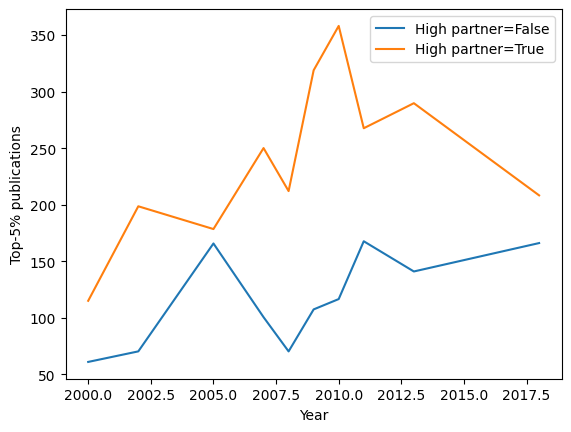

In [136]:
cut = df['PartnerAvgTop5Percent'].median()
df['HighPartner'] = df['PartnerAvgTop5Percent'] > cut

avg_trend = (
    df.groupby(['year', 'HighPartner'])['Top5PercentPublications']
      .mean().reset_index()
)

for grp, g in avg_trend.groupby('HighPartner'):
    plt.plot(g['year'], g['Top5PercentPublications'], label=f'High partner={grp}')
plt.legend(); plt.xlabel('Year'); plt.ylabel('Top-5% publications'); plt.show()


In [137]:
# assume citations_df: AffiliationId, Year, TotalPublications

# use a baseline window or lagged year; here: within-year top decile
yearly_cut = (
    citations_df
    .groupby('Year')['TotalPublications']
    .quantile(0.9)
    .rename('elite_cutoff')
    .reset_index()
)

citations_elite = citations_df.merge(yearly_cut, on='Year', how='left')
citations_elite['Elite'] = (
    citations_elite['TotalPublications'] >= citations_elite['elite_cutoff']
).astype(int)


In [138]:
# tag elite on AffiliationId_2 side
edges_elite = edges_df.merge(
    citations_elite[['AffiliationId', 'Year', 'Elite', 'TotalPublications']]
        .rename(columns={'AffiliationId': 'AffiliationId_2',
                         'Elite': 'Elite_2',
                         'TotalPublications': 'TotalPublications_2'}),
    on=['AffiliationId_2', 'Year'],
    how='left'
)

# ego-level measures for AffiliationId_1
elite_strength = (
    edges_elite.groupby(['Year', 'AffiliationId_1'])
    .agg(
        AnyEliteTie=('Elite_2', lambda x: int((x == 1).any())),
        NumEliteTies=('Elite_2', lambda x: (x == 1).sum()),
        ShareEliteTies=('Elite_2', lambda x: (x == 1).mean()),
        EliteWeightedStrength=('Elite_2', lambda x: 0),  # placeholder
    )
    .reset_index()
)

# weighted strength just for elites:
tmp = (
    edges_elite[edges_elite['Elite_2'] == 1]
    .groupby(['Year', 'AffiliationId_1'])['WeightNorm']
    .sum()
    .rename('EliteWeightedStrength')
    .reset_index()
)

elite_strength = elite_strength.drop(columns=['EliteWeightedStrength']) \
    .merge(tmp, on=['Year', 'AffiliationId_1'], how='left') \
    .fillna({'EliteWeightedStrength': 0})


In [139]:
school_panel = citations_df.merge(
    elite_strength,
    left_on=['AffiliationId', 'Year'],
    right_on=['AffiliationId_1', 'Year'],
    how='left'
).sort_values(['AffiliationId','Year'])

for col in ['AnyEliteTie', 'NumEliteTies', 'ShareEliteTies', 'EliteWeightedStrength']:
    school_panel[col] = school_panel[col].fillna(0)

school_panel['ΔPublications'] = school_panel.groupby('AffiliationId')['TotalPublications'].diff()
df = school_panel.dropna(subset=['ΔPublications'])

import statsmodels.formula.api as smf

m_elite = smf.ols(
    'ΔPublications ~ AnyEliteTie + NumEliteTies + C(Year)',
    data=df
).fit(cov_type='cluster', cov_kwds={'groups': df['AffiliationId']})
print(m_elite.summary())


                            OLS Regression Results                            
Dep. Variable:          ΔPublications   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     20.00
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.82e-71
Time:                        00:12:11   Log-Likelihood:            -7.3037e+05
No. Observations:              154118   AIC:                         1.461e+06
Df Residuals:                  154097   BIC:                         1.461e+06
Df Model:                          20                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5873      0.274     

In [140]:
from linearmodels import PanelOLS
import pandas as pd

panel = df.set_index(['AffiliationId','Year'])
fe_elite = PanelOLS.from_formula(
    'TotalPublications ~ AnyEliteTie + NumEliteTies + EntityEffects + TimeEffects',
    data=panel
).fit(cov_type='clustered', cluster_entity=True)
print(fe_elite.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:      TotalPublications   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.0055
No. Observations:              154118   R-squared (Within):               0.0016
Date:                Fri, Nov 07 2025   R-squared (Overall):             -0.0050
Time:                        00:12:12   Log-likelihood                -8.635e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      98.663
Entities:                       16694   P-value                           0.0000
Avg Obs:                       9.2319   Distribution:                F(2,137404)
Min Obs:                       1.0000                                           
Max Obs:                       19.000   F-statistic (robust):             4.5551
                            